<a href="https://colab.research.google.com/github/yannuma/PrivacyProject/blob/main/Model_Creation/Main_PrivacyProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opacus
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator
import tarfile
import torch
import requests
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torchvision
import torch.utils.data as torch_data
import torchvision.transforms as transforms
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time
from google.colab import files

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 5.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
response = requests.get(f'https://www.comp.nus.edu.sg/~reza/files/dataset_texas.tgz')
if response.status_code == 200:
    with open(f'dataset_texas.tgz', 'wb') as file:
        file.write(response.content)
    print("Download completed successfully.")
else:
    print(f"Failed to download file: {response.status_code}")

with tarfile.open(f'dataset_texas.tgz') as f:
    f.extractall(f'data/')

with open('data/texas/100/feats', 'r') as f:
    features = f.readlines()
with open('data/texas/100/labels', 'r') as f:
    labels = f.readlines()

print(len(features))
print(len(labels))

Download completed successfully.
67330
67330


In [3]:
class NetSeq(nn.Module):
    def __init__(self):
        super(NetSeq, self).__init__()
        self.fc1 = nn.Linear(6169, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 101)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

def calc_accuracy(loader, network, device):
    correct = 0
    total = 0
    for data in loader:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = network(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    return (correct / total, total)

In [6]:
def train_nn(trainloader, testloader, lr, epochs, network_output):
		losses = []
		train_accs = []
		test_accs = []
		max_accuracy = 0
		best_model_path = 'best_model.pth'

		device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
		network = NetSeq().to(device)
		optimizer = torch.optim.Adam(network.parameters(), lr = lr)
		criterion = nn.CrossEntropyLoss()

		#print('Start training on', device)

		for epoch in range(epochs):

			#print('Epoch: {}'.format(epoch + 1))

			epoch_loss = []

			for i, data in enumerate(trainloader, 0):
				inputs, labels = data
				inputs, labels = inputs.to(device), labels.to(device)
				optimizer.zero_grad()
				outputs = network(inputs)
				loss = criterion(outputs, labels)
				epoch_loss.append(loss.item())
				loss.backward()
				optimizer.step()

			losses.append(np.mean(epoch_loss))

			# Compute accuracy on training data
			with torch.no_grad():
				acc_tuple = calc_accuracy(trainloader, network, device)

			#print('Accuracy of the network on %d train inputs: %d %%' % (acc_tuple[1], 100 * acc_tuple[0]))
			train_accs.append(acc_tuple[0])

			# Validate all classes
			with torch.no_grad():
				acc_tuple = calc_accuracy(testloader, network, device)

			#print('Accuracy of the network on %d test inputs: %d %%' % (acc_tuple[1], 100 * acc_tuple[0]))
			test_accs.append(acc_tuple[0])
			if acc_tuple[0] > max_accuracy:
				max_accuracy = acc_tuple[0]
				if network_output:
					torch.save(network.state_dict(), best_model_path)

		if network_output:
			network.load_state_dict(torch.load(best_model_path))
			network.to('cpu')
			return network
		else:
			#print('Final accuracy: ', max_accuracy)
			return max_accuracy

def train_nn_DP(trainloader, testloader, lr, epochs, network_output, C, epsilon):
		losses = []
		train_accs = []
		test_accs = []
		max_accuracy = 0
		best_model_path = 'best_model.pth'
		Delta = 1e-5

		device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

		network = NetSeq().to(device)
		network = ModuleValidator.fix(network)
		network = network.to(device)
		optimizer = torch.optim.Adam(network.parameters(), lr = lr)
		criterion = nn.CrossEntropyLoss()

		privacy_engine = PrivacyEngine()
		network, optimizer, trainloader = privacy_engine.make_private_with_epsilon(
    	module=network,
    	optimizer=optimizer,
    	data_loader=trainloader,
    	max_grad_norm=C,
			target_epsilon = epsilon,
			target_delta = Delta,
			epochs = epochs
			)

		network.to(device)


		#print('Start training on', device)

		for epoch in range(epochs):

			#print('Epoch: {}'.format(epoch + 1))

			epoch_loss = []

			for i, data in enumerate(trainloader, 0):
				inputs, labels = data
				inputs, labels = inputs.to(device), labels.to(device)
				optimizer.zero_grad()
				outputs = network(inputs)
				loss = criterion(outputs, labels)
				epoch_loss.append(loss.item())
				loss.backward()
				optimizer.step()

			losses.append(np.mean(epoch_loss))

			# Compute accuracy on training data
			with torch.no_grad():
				acc_tuple = calc_accuracy(trainloader, network, device)

			#print('Accuracy of the network on %d train inputs: %d %%' % (acc_tuple[1], 100 * acc_tuple[0]))
			train_accs.append(acc_tuple[0])

			# Validate all classes
			with torch.no_grad():
				acc_tuple = calc_accuracy(testloader, network, device)

			#print('Accuracy of the network on %d test inputs: %d %%' % (acc_tuple[1], 100 * acc_tuple[0]))
			test_accs.append(acc_tuple[0])
			if acc_tuple[0] > max_accuracy:
				max_accuracy = acc_tuple[0]
				if network_output:
					torch.save(network.state_dict(), best_model_path)

		epsilon = privacy_engine.get_epsilon(delta=Delta)
		#print("Our Privacy Budget is:", epsilon)

		if network_output:
			network.load_state_dict(torch.load(best_model_path))
			network.to('cpu')
			return network
		else:
			#print('Final accuracy: ', max_accuracy)
			return max_accuracy

In [7]:
features_list = [list(map(int, ''.join(feature.split()).split(','))) for feature in features]
labels_list = [int(label.strip()) for label in labels]
size = int(0.8 * len(features))
feat_tens_train = torch.tensor(features_list[:size], dtype=torch.float)
l_tens_train = torch.tensor(labels_list[:size], dtype=torch.long)
feat_tens_test = torch.tensor(features_list[size:], dtype=torch.float)
l_tens_test = torch.tensor(labels_list[size:], dtype=torch.long)
dataset_train = TensorDataset(feat_tens_train, l_tens_train)
dataset_test = TensorDataset(feat_tens_test, l_tens_test)

In [ ]:
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]
epoch_numbers = [5, 10, 20]
results = []

for lr, batch, epochs in itertools.product(learning_rates, batch_sizes, epoch_numbers):
    #print(f"Training with lr={lr}, batch size={batch}, epochs={epochs}")
    trainloader = DataLoader(dataset_train, batch_size=batch, shuffle=True)
    testloader = DataLoader(dataset_test, batch_size=batch, shuffle=True)

    accuracy = train_nn(trainloader, testloader, lr, epochs, False)
    results.append((lr, batch, epochs, accuracy))

# Find the best parameters based on accuracy
best_params = max(results, key=lambda x: x[3])
print(f"Best parameters found: lr={best_params[0]}, batch size={best_params[1]}, epochs={best_params[2]} with accuracy={best_params[3]}")

df_results = pd.DataFrame(results, columns=['learning_rate', 'batch_size', 'epochs', 'accuracy'])
df_results

Best parameters found: lr=0.001, batch size=64, epochs=20 with accuracy=0.636863211050052


,learning_rate,batch_size,epochs,accuracy
0,0.001,16,5,0.624684
1,0.001,16,10,0.625427
2,0.001,16,20,0.623348
3,0.001,32,5,0.628397
4,0.001,32,10,0.624684
5,0.001,32,20,0.627729
6,0.001,64,5,0.633819
7,0.001,64,10,0.633744
8,0.001,64,20,0.636863
9,0.010,16,5,0.518788


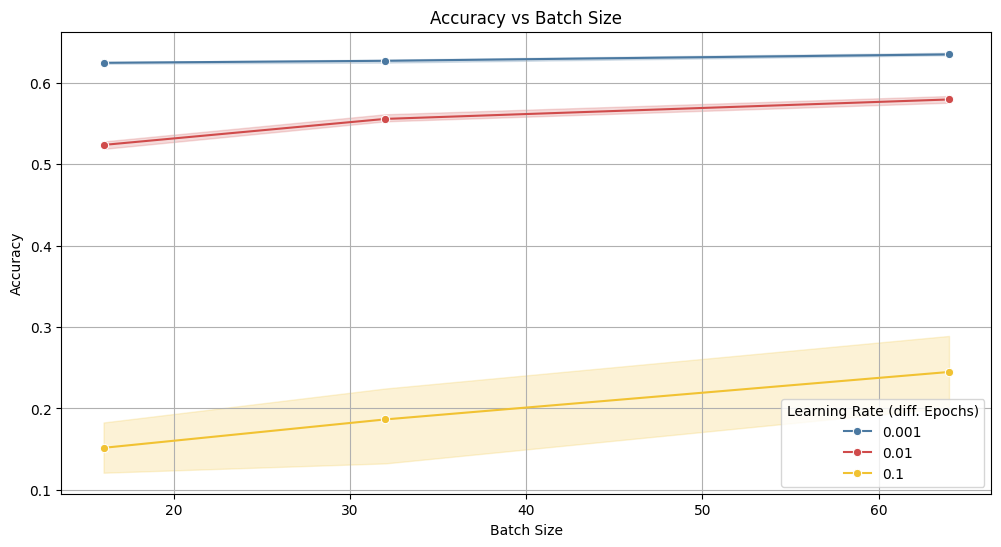

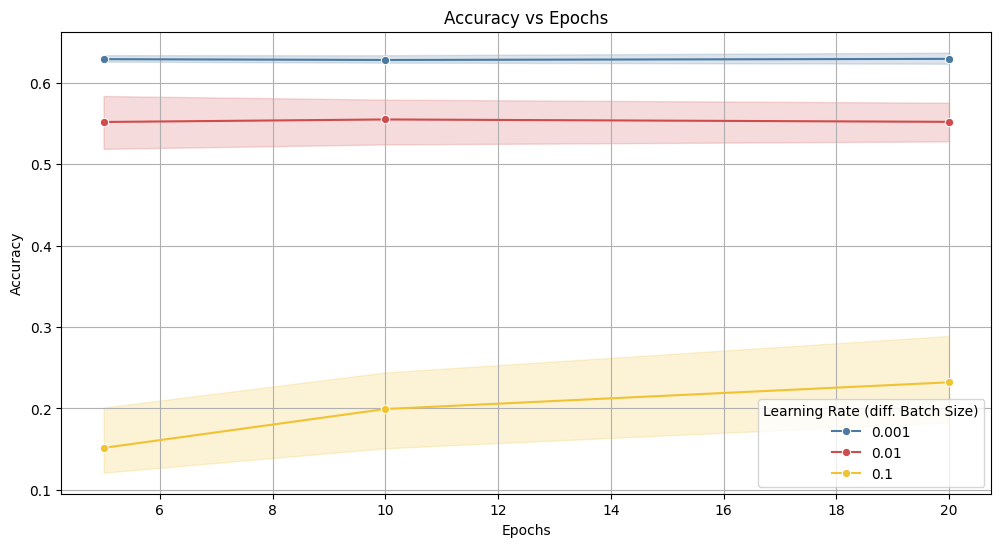

In [ ]:
#df_results.to_csv('df_results.csv', index=False)
#files.download('df_results.csv')

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_results, x='batch_size', y='accuracy', hue='learning_rate', dashes=True, palette=['#4b79a1', '#d04b4b', '#f1c232'], marker='o')
plt.title('Accuracy vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.legend(title='Learning Rate (diff. Epochs)')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_results, x='epochs', y='accuracy', hue='learning_rate', dashes=False, palette=['#4b79a1', '#d04b4b', '#f1c232'], marker='o')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(title='Learning Rate (diff. Batch Size)')
plt.grid(True)
plt.show()

In [ ]:
#Best Model from Information above
lr = best_params[0]
epochs = best_params[2]
batch = best_params[1]

trainloader = DataLoader(dataset_train, batch_size=batch, shuffle=True)
testloader = DataLoader(dataset_test, batch_size=batch, shuffle=True)

model = train_nn(trainloader, testloader, lr, epochs, True, False)

In [ ]:
torch.save(model.state_dict(), 'model.pth')
from google.colab import files
files.download('model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
##Differential Privacy
lr = 0.001
batch = 64
epochs = 10
epsilon = 20

trainloader = DataLoader(dataset_train, batch_size=batch, shuffle=True)
testloader = DataLoader(dataset_test, batch_size=batch, shuffle=True)

acc_list = []
runs = 3
for C in range(1, 10):
  #print("Start training for C = ", C )
  accuracy = 0
  for _ in range(runs):
    accuracy += train_nn_DP(trainloader, testloader, lr, epochs, False, C, epsilon)/runs
  acc_list.append(accuracy)

/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


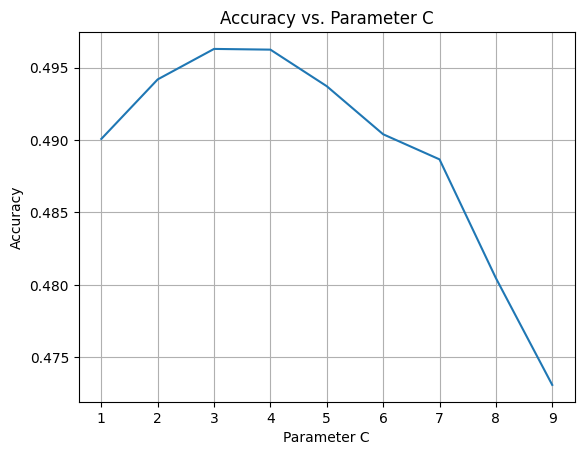

In [ ]:
#Plot
print()
c = list(range(1, 10))
sns.lineplot(x=c, y=acc_list)
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Parameter C')
plt.grid(True)
plt.show()

In [ ]:
#Best Value for Parameter C is 3
C = 3
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]
epoch_numbers = [10, 20]

epsilon = 20
results20 = []
for lr, batch, epochs in itertools.product(learning_rates, batch_sizes, epoch_numbers):
    #print(f"Training with lr={lr}, batch size={batch}, epochs={epochs}")
    trainloader = DataLoader(dataset_train, batch_size=batch, shuffle=True)
    testloader = DataLoader(dataset_test, batch_size=batch, shuffle=True)

    accuracy = train_nn_DP(trainloader, testloader, lr, epochs, False, C, epsilon)
    results20.append((lr, batch, epochs, epsilon, accuracy))

# Find the best parameters based on accuracy
best_params = max(results20, key=lambda x: x[4])
print(f"Best parameters found: lr={best_params[0]}, batch size={best_params[1]}, epochs={best_params[2]} with accuracy={best_params[4]}")

epsilon = 10
results10 = []
for lr, batch, epochs in itertools.product(learning_rates, batch_sizes, epoch_numbers):
    #print(f"Training with lr={lr}, batch size={batch}, epochs={epochs}")
    trainloader = DataLoader(dataset_train, batch_size=batch, shuffle=True)
    testloader = DataLoader(dataset_test, batch_size=batch, shuffle=True)

    accuracy = train_nn_DP(trainloader, testloader, lr, epochs, False, C, epsilon)
    results10.append((lr, batch, epochs, epsilon, accuracy))

# Find the best parameters based on accuracy
best_params = max(results10, key=lambda x: x[4])
print(f"Best parameters found: lr={best_params[0]}, batch size={best_params[1]}, epochs={best_params[2]} with accuracy={best_params[4]}")

epsilon = 1
results1 = []
for lr, batch, epochs in itertools.product(learning_rates, batch_sizes, epoch_numbers):
    #print(f"Training with lr={lr}, batch size={batch}, epochs={epochs}")
    trainloader = DataLoader(dataset_train, batch_size=batch, shuffle=True)
    testloader = DataLoader(dataset_test, batch_size=batch, shuffle=True)

    accuracy = train_nn_DP(trainloader, testloader, lr, epochs, False, C, epsilon)
    results1.append((lr, batch, epochs, epsilon, accuracy))

# Find the best parameters based on accuracy
best_params = max(results1, key=lambda x: x[4])
print(f"Best parameters found: lr={best_params[0]}, batch size={best_params[1]}, epochs={best_params[2]} with accuracy={best_params[4]}")

results_combined = results1 + results10 + results20
df_combined = pd.DataFrame(results_combined, columns=['learning_rate', 'batch_size', 'epochs', 'epsilon', 'accuracy'])
df_combined

Best parameters found: lr=0.001, batch size=128, epochs=20 with accuracy=0.5512401604039804
Best parameters found: lr=0.001, batch size=128, epochs=20 with accuracy=0.5336402792217436
Best parameters found: lr=0.001, batch size=64, epochs=20 with accuracy=0.45061636714688846


,learning_rate,batch_size,epochs,epsilon,accuracy
0,0.001,32,10,1,0.390613
1,0.001,32,20,1,0.420986
2,0.001,64,10,1,0.400045
3,0.001,64,20,1,0.450616
4,0.001,128,10,1,0.364993
5,0.001,128,20,1,0.448537
6,0.010,32,10,1,0.103446
7,0.010,32,20,1,0.101812
8,0.010,64,10,1,0.175330
9,0.010,64,20,1,0.168721


In [10]:
lr = 0.001
batch = 128
epochs = 20
C = 3
trainloader = DataLoader(dataset_train, batch_size=batch, shuffle=True)
testloader = DataLoader(dataset_test, batch_size=batch, shuffle=True)
model_E = train_nn_DP(trainloader, testloader, lr, epochs, True, 3, 20)

torch.save(model_E.state_dict(), 'model_E.pth')
files.download('model_E.pth')

model_X = train_nn_DP(trainloader, testloader, lr, epochs, True, 3, 10)

torch.save(model_X.state_dict(), 'model_X.pth')
files.download('model_X.pth')

batch = 64
trainloader = DataLoader(dataset_train, batch_size=batch, shuffle=True)
testloader = DataLoader(dataset_test, batch_size=batch, shuffle=True)
model_Y = train_nn_DP(trainloader, testloader, lr, epochs, True, 3, 1)

torch.save(model_Y.state_dict(), 'model_Y.pth')
files.download('model_Y.pth')

/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

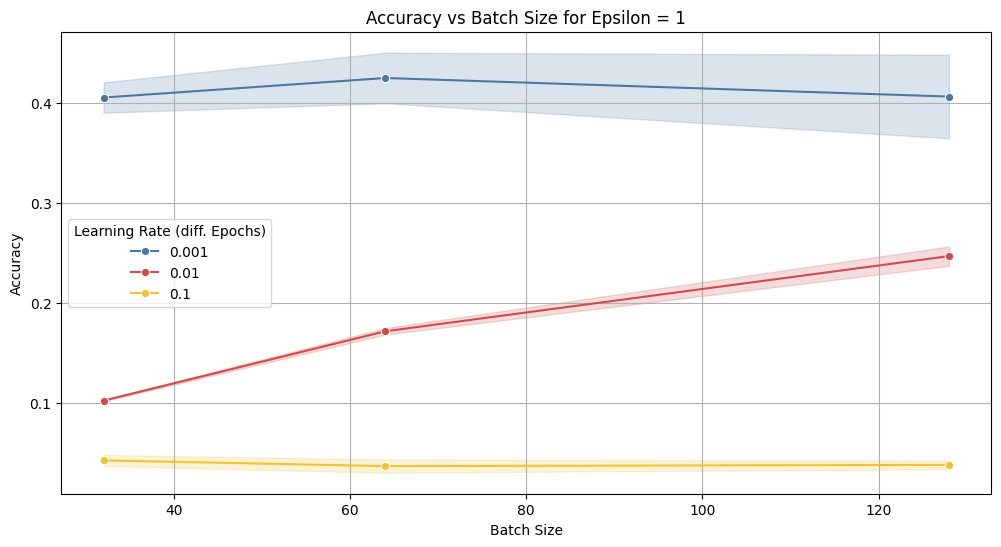

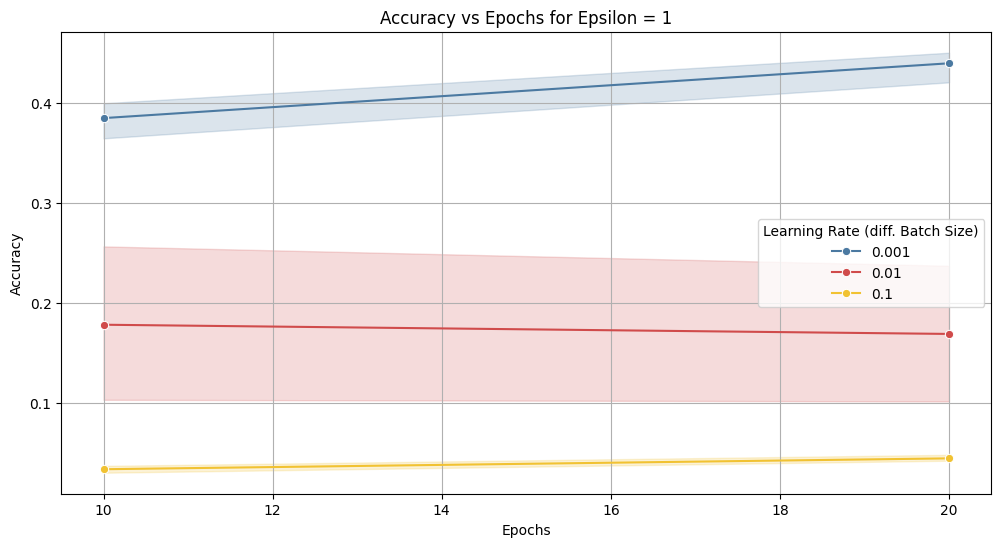

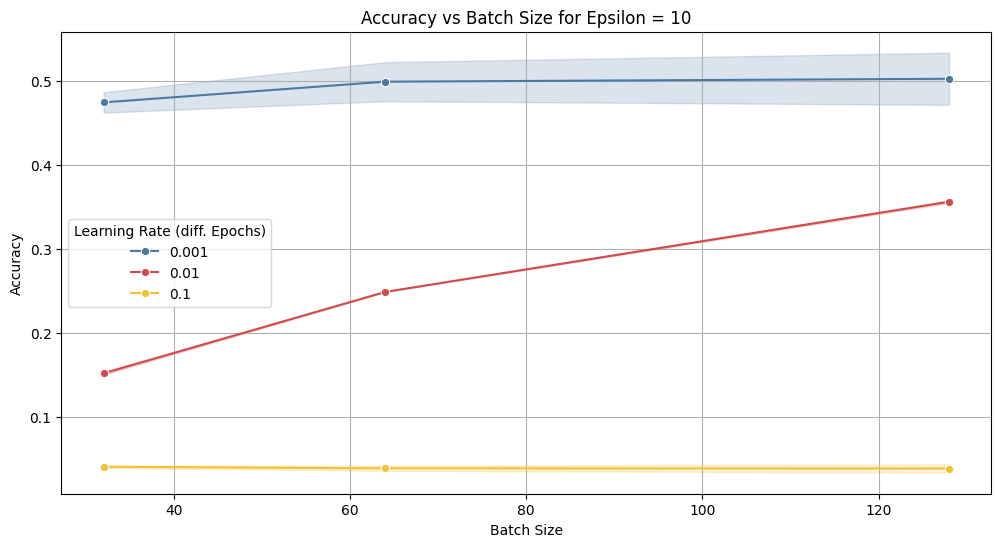

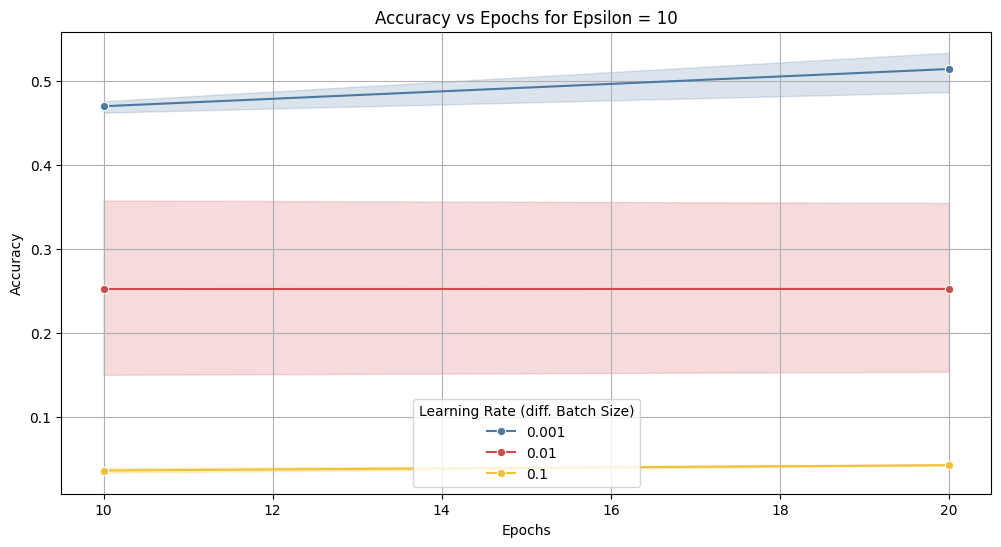

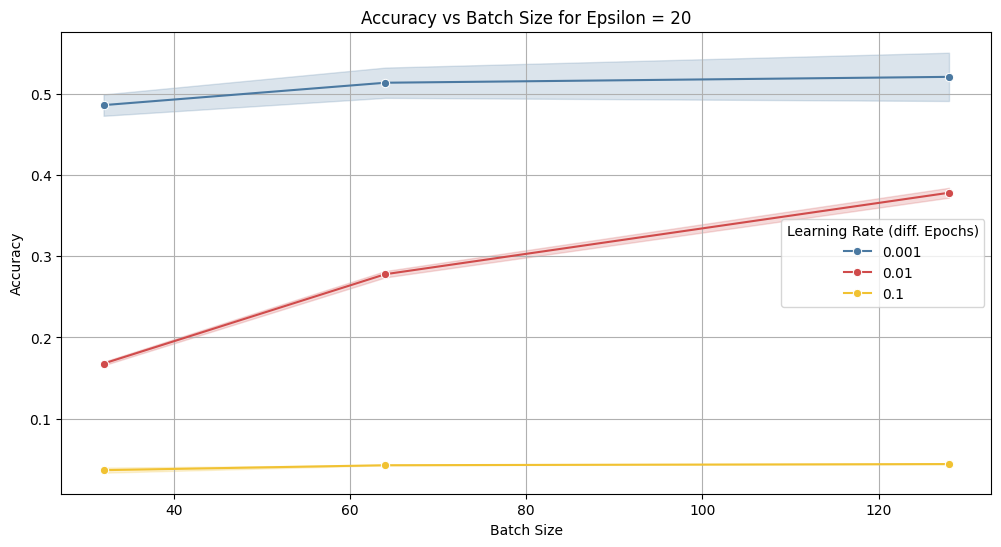

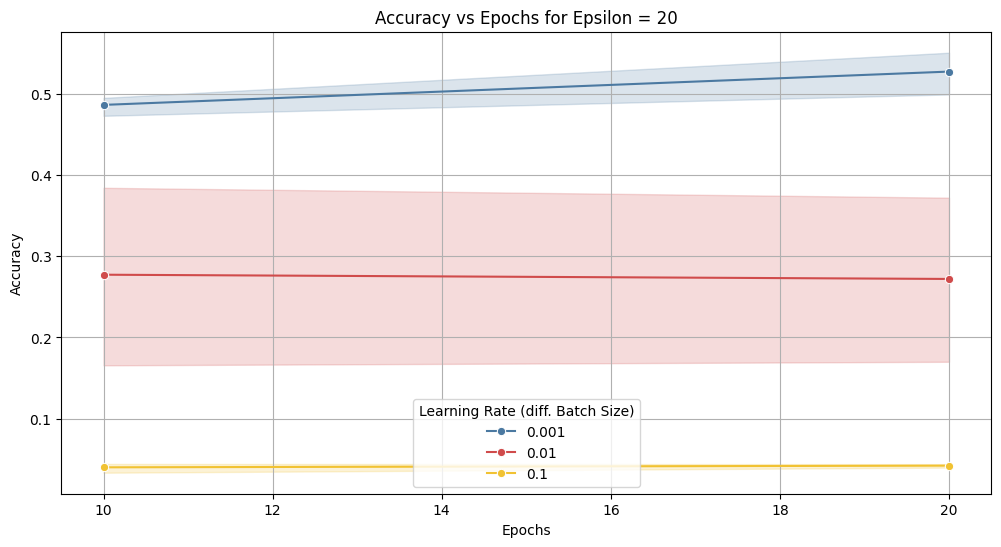

In [9]:
#df_combined.to_csv('df_combined.csv', index=False)
#files.download('df_combined.csv')
#uploaded = files.upload()
#df_combined = pd.read_csv('df_combined.csv')
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_combined[df_combined['epsilon']==1], x='batch_size', y='accuracy', hue='learning_rate', dashes=True, palette=['#4b79a1', '#d04b4b', '#f1c232'], marker='o')
plt.title('Accuracy vs Batch Size for Epsilon = 1')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.legend(title='Learning Rate (diff. Epochs)')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_combined[df_combined['epsilon']==1], x='epochs', y='accuracy', hue='learning_rate', dashes=False, palette=['#4b79a1', '#d04b4b', '#f1c232'], marker='o')
plt.title('Accuracy vs Epochs for Epsilon = 1')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(title='Learning Rate (diff. Batch Size)')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_combined[df_combined['epsilon']==10], x='batch_size', y='accuracy', hue='learning_rate', dashes=True, palette=['#4b79a1', '#d04b4b', '#f1c232'], marker='o')
plt.title('Accuracy vs Batch Size for Epsilon = 10')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.legend(title='Learning Rate (diff. Epochs)')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_combined[df_combined['epsilon']==10], x='epochs', y='accuracy', hue='learning_rate', dashes=False, palette=['#4b79a1', '#d04b4b', '#f1c232'], marker='o')
plt.title('Accuracy vs Epochs for Epsilon = 10')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(title='Learning Rate (diff. Batch Size)')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_combined[df_combined['epsilon']==20], x='batch_size', y='accuracy', hue='learning_rate', dashes=True, palette=['#4b79a1', '#d04b4b', '#f1c232'], marker='o')
plt.title('Accuracy vs Batch Size for Epsilon = 20')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.legend(title='Learning Rate (diff. Epochs)')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_combined[df_combined['epsilon']==20], x='epochs', y='accuracy', hue='learning_rate', dashes=False, palette=['#4b79a1', '#d04b4b', '#f1c232'], marker='o')
plt.title('Accuracy vs Epochs for Epsilon = 20')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(title='Learning Rate (diff. Batch Size)')
plt.grid(True)
plt.show()


In [ ]:
#Create Plot for the Report for the best Models
data = {
    "Model": ["NN", "Opacus NN DP", "Opacus NN DP", "Opacus NN DP", "Pyvacy NN NP", "Pyvacy NN NP", "Pyvacy NN NP"],
    "Accuracy": ["0.63","0.55" ,"0.53","0.45", "0.37", "0.38", "0.26"],
    "Epsilon": ["-", "20", "10", "1", "28", "12", "1.3"],
    "Epochs": [ "10", "20", "20", "20", "20", "20", "20"]
  }
df = pd.DataFrame(data)
df

,Model,Accuracy,Epsilon,Epochs
0,NN,0.63,-,5
1,Opacus NN DP,0.55,20,20
2,Opacus NN DP,0.53,10,20
3,Opacus NN DP,0.45,1,20
4,Pyvacy NN NP,0.37,28,20
5,Pyvacy NN NP,0.38,12,20
6,Pyvacy NN NP,0.26,1.3,20


In [ ]:
lr = 0.001
batch = 64
epochs = [5, 10, 20]
eps = [1, 10, 20]
C = 3
n = 3
trainloader = DataLoader(dataset_train, batch_size=batch, shuffle=True)
testloader = DataLoader(dataset_test, batch_size=batch, shuffle=True)

analyse = []

for epoch in epochs:
    for _ in range(n):
        start_time = time.time()
        accuracy = train_nn(trainloader, testloader, lr, epoch, False)
        end_time = time.time()
        analyse.append((epoch, 0 ,accuracy, end_time - start_time))

for epoch in epochs:
    for ep in eps:
        for _ in range(n):
            start_time = time.time()
            accuracy = train_nn_DP(trainloader, testloader, lr, epoch, False, C, ep)
            end_time = time.time()
            analyse.append((epoch, ep, accuracy, end_time - start_time))

df_analyse = pd.DataFrame(analyse, columns=['epochs', 'epsilon', 'accuracy', 'time'])

/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


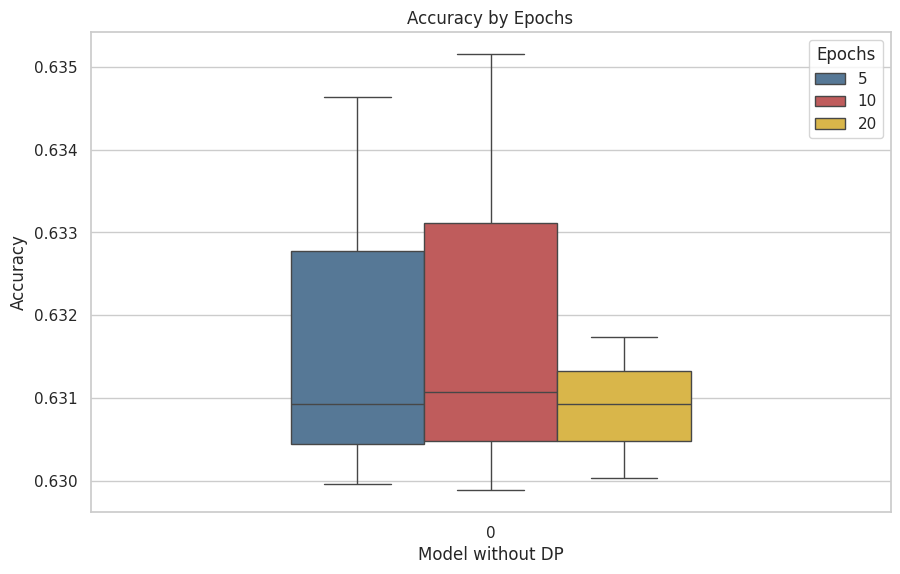

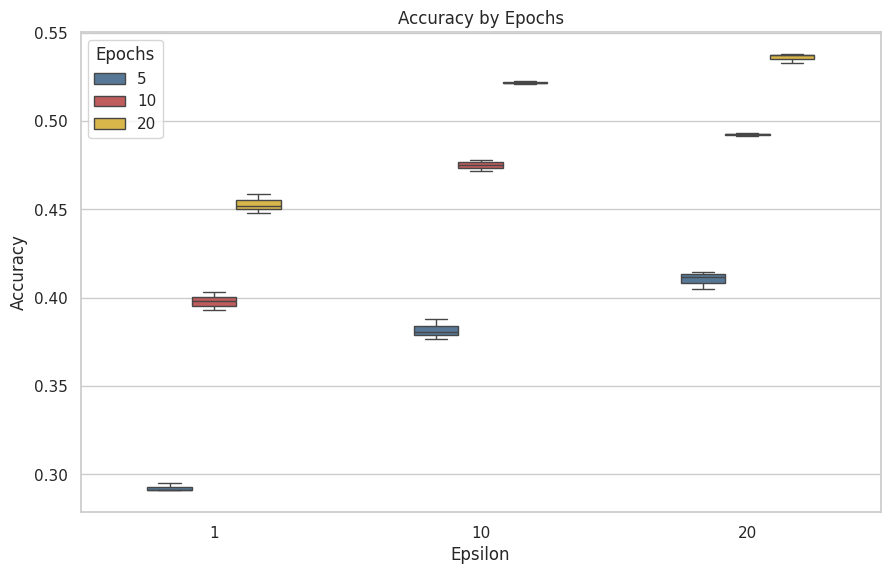

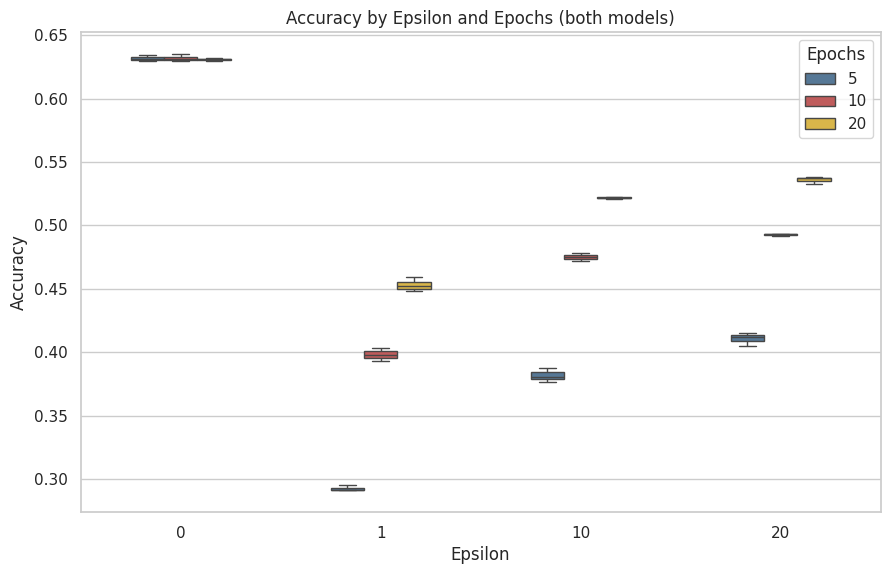

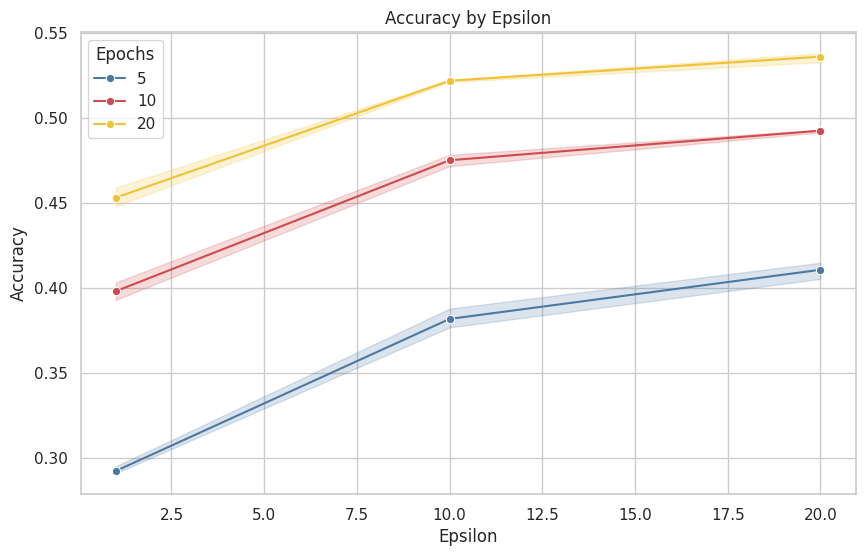

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

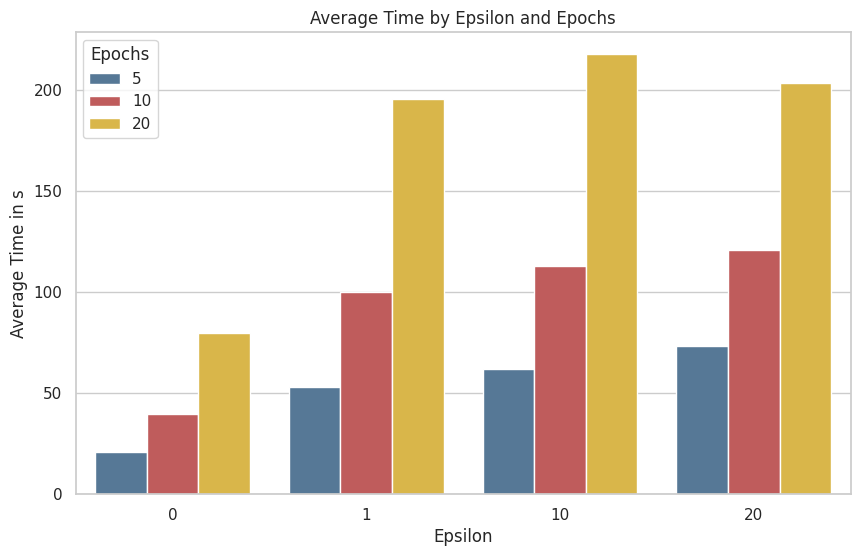

In [ ]:
#df_analyse.to_csv('df_analyse.csv', index=False)
#files.download('df_analyse.csv')
plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(x='epsilon', y='accuracy', hue='epochs', data=df_analyse[df_analyse['epsilon'] == 0], palette=['#4b79a1', '#d04b4b', '#f1c232'], width=0.5)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3)
plt.title('Accuracy by Epochs')
plt.xlabel('Model without DP')
plt.ylabel('Accuracy')
handles, labels = box_plot.get_legend_handles_labels()
box_plot.legend(handles=handles, labels=labels, title='Epochs')
plt.savefig('box_plot1.png')
plt.show()
#files.download('box_plot1.png')

plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(x='epsilon', y='accuracy', hue='epochs', data=df_analyse[df_analyse['epsilon'] != 0], palette=['#4b79a1', '#d04b4b', '#f1c232'], width=0.5)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3)
plt.title('Accuracy by Epochs')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
handles, labels = box_plot.get_legend_handles_labels()
box_plot.legend(handles=handles, labels=labels, title='Epochs')
plt.savefig('box_plot2.png')
plt.show()
#files.download('box_plot2.png')

plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(x='epsilon', y='accuracy', hue='epochs', data=df_analyse, palette=['#4b79a1', '#d04b4b', '#f1c232'], width=0.5)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3)
plt.title('Accuracy by Epsilon and Epochs (both models)')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
handles, labels = box_plot.get_legend_handles_labels()
box_plot.legend(handles=handles, labels=labels, title='Epochs')
plt.savefig('box_plot3.png')
plt.show()
#files.download('box_plot3.png')

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
line_plot = sns.lineplot(x='epsilon', y='accuracy', hue='epochs', data=df_analyse[df_analyse['epsilon'] != 0], palette=['#4b79a1', '#d04b4b', '#f1c232'], marker='o')
plt.title('Accuracy by Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.legend(title='Epochs')
plt.savefig('line_plot.png')
plt.show()
#files.download('line_plot.png')

#Barplot
sns.set(style="whitegrid")
avg_time = df_analyse.groupby(['epsilon', 'epochs'])['time'].mean().unstack()
avg_time_long = avg_time.reset_index().melt(id_vars='epsilon', var_name='epochs', value_name='time')

# Create the bar plot
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='epsilon', y='time', hue='epochs', data=avg_time_long, palette=['#4b79a1', '#d04b4b', '#f1c232'])
plt.title('Average Time by Epsilon and Epochs')
plt.xlabel('Epsilon')
plt.ylabel('Average Time in s')
plt.legend(title='Epochs')
plt.savefig('bar_plot.png')
plt.show()
#files.download('bar_plot.png')